# Forecasting Sine using LSTMs

## This Notebook is copied from the network.ipynb (Forecasting Water Levels using LSTMs). It shows, that generally, LSTMs are able to be used on highly repetitive seasonal time series data. 

This notebook generates a sine curve, which should be easily modelable by an LSTM, since it repeats itself often and is seasonal.

In [520]:
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import RobustScaler


In [ ]:
path = 'results/'

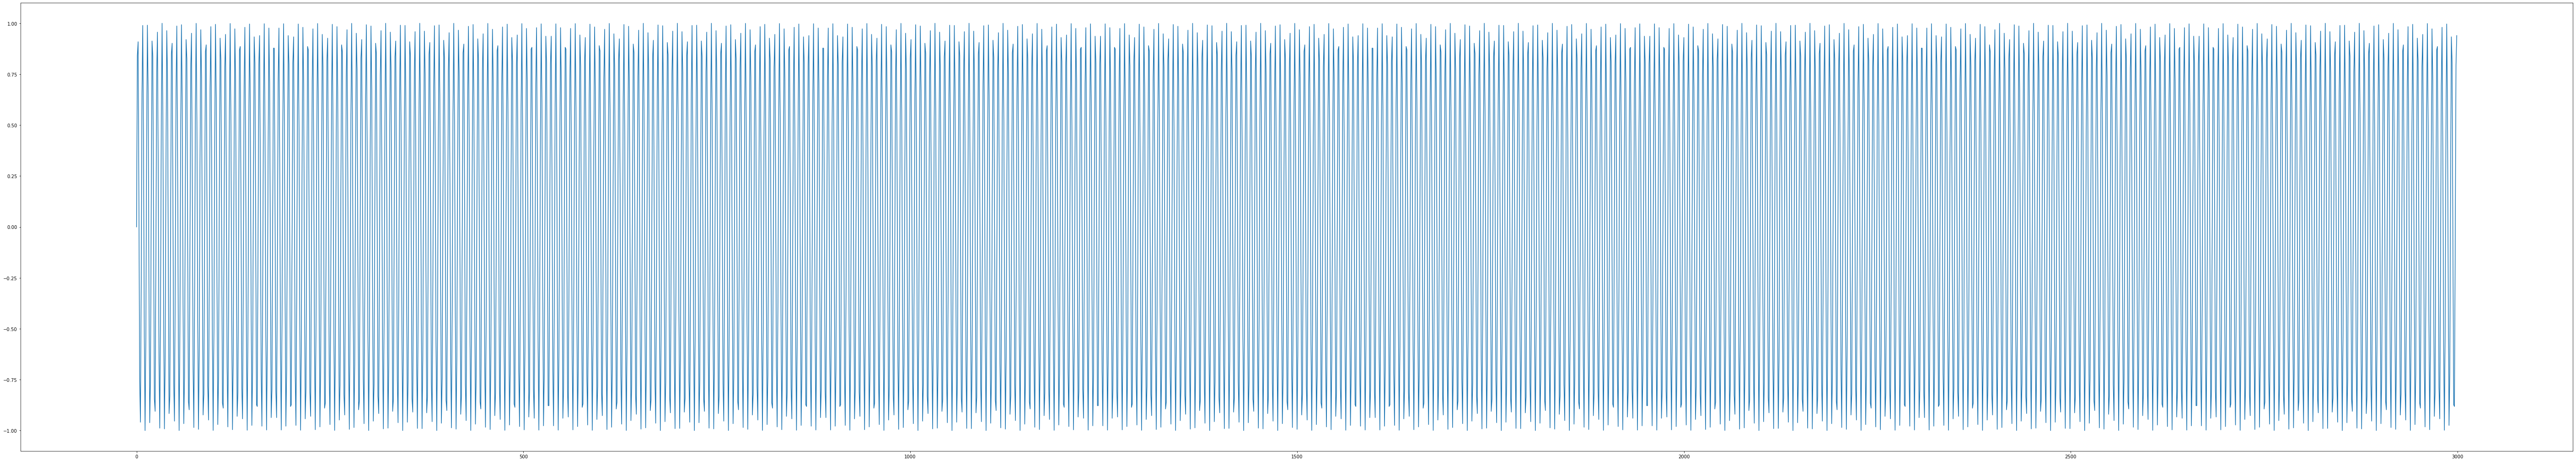

In [521]:
plt.figure(1, figsize=(100,18))
time = np.arange(0, 3000);
amplitude = np.sin(time)
dic = {'date': time, 'level': amplitude}
df = pd.DataFrame.from_dict(dic)
plt.plot(time, amplitude)

In [522]:
print(df.head())

   date     level
0     0  0.000000
1     1  0.841471
2     2  0.909297
3     3  0.141120
4     4 -0.756802


In [523]:
date_time = pd.to_datetime(df.pop('date'), format='%Y.%m.%d')

Delete strong outliers with the help of the zscore.

In [527]:
column_indices = {name: i for i, name in enumerate(df.columns)}
train_df = df[0:int(len(df)*0.7)]
val_df = df[int(len(df)*0.7):int(len(df)*0.9)]
test_df = df[int(len(df)*0.9):]

num_features = df.shape[1]

In [528]:
train_df.describe()

,level
count,2100.000000
mean,0.000133
std,0.707094
min,-0.999991
25%,-0.708563
50%,-0.000015
75%,0.708585
max,0.999991


In [529]:
test_df.describe()

,level
count,300.000000
mean,0.000375
std,0.709673
min,-0.999989
25%,-0.716332
50%,-0.004426
75%,0.722480
max,0.999991


In [530]:
print(f'Train mean: {train_df["level"].mean()}, Train std: {train_df["level"].std()}')

Train mean: 0.00013342855839607837, Train std: 0.707094302431571


In [531]:
print(f'Validation mean: {val_df["level"].mean()}, {val_df["level"].std()}')

Validation mean: 0.0021766980923650426, 0.7076867477021133


In [532]:
print(f'Test mean: {test_df["level"].mean()}, {test_df["level"].std()}')

Test mean: 0.000374723964187178, 0.7096733840293882


Test, if split was successful.

In [533]:
assert(len(train_df) + len(val_df) + len(test_df) == len(df))

In [534]:
pre_transformation = train_df

In [535]:
scaler = RobustScaler()
scaler.fit(train_df.values)
train_scaled = scaler.transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

/home/pascal/anaconda3/envs/forecasting/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/home/pascal/anaconda3/envs/forecasting/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/home/pascal/anaconda3/envs/forecasting/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


In [536]:
train_df = pd.DataFrame(train_scaled, index=train_df.index, columns=train_df.columns)
val_df = pd.DataFrame(val_scaled, index=val_df.index, columns=val_df.columns)
test_df = pd.DataFrame(test_scaled, index=test_df.index, columns=test_df.columns)

In [537]:
train_df

,level
0,0.000011
1,0.593788
2,0.641650
3,0.099591
4,-0.534021
...,...
2095,0.302039
2096,-0.373441
2097,-0.705571
2098,-0.388993


In [538]:
pre_transformation

,level
0,0.000000
1,0.841471
2,0.909297
3,0.141120
4,-0.756802
...,...
2095,0.428019
2096,-0.529236
2097,-0.999914
2098,-0.551276


<AxesSubplot:>

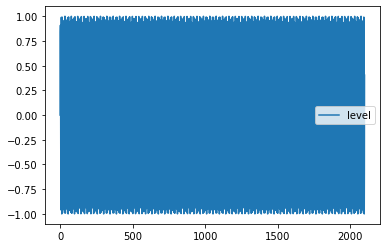

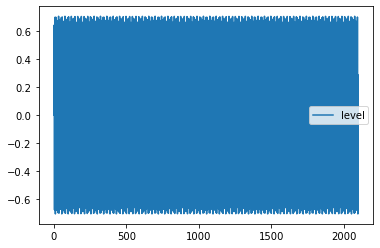

In [539]:
pre_transformation.plot()
train_df.plot()

In [540]:
print(f' The data pre transformation is in range [{pre_transformation["level"].min()},  {pre_transformation["level"].max()}]\n'
      f' the data after transformation is in range: [{round(test_df["level"].min(),2)}, {round(test_df["level"].max(), 2)}]')
      

 The data pre transformation is in range [-0.9999908622413068,  0.9999907329205332]
 the data after transformation is in range: [-0.71, 0.71]


In [541]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                   train_df=train_df, val_df=val_df, test_df=test_df,
                   label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [542]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [543]:
def plot(self, model=None, plot_col='level', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue
    
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Day')

WindowGenerator.plot = plot


In [544]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [545]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [546]:
single_step_window = WindowGenerator(
    input_width=30, label_width=30, shift=6,
    label_columns=['level'])
single_step_window

single_step_window


Total window size: 36
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
 30 31 32 33 34 35]
Label column name(s): ['level']

In [547]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:single_step_window.total_window_size]),
                           np.array(train_df[100:100+single_step_window.total_window_size]),
                           np.array(train_df[200:200+single_step_window.total_window_size])])

example_inputs, example_labels = single_step_window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 36, 1)
Inputs shape: (3, 30, 1)
Labels shape: (3, 30, 1)


In [548]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 30, 1)
Labels shape (batch, time, features): (32, 30, 1)


In [549]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]


In [550]:
baseline = Baseline(label_index=column_indices['level'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)


18/18 [==============================] - 0s 602us/step - loss: 0.0198 - mean_absolute_error: 0.1268


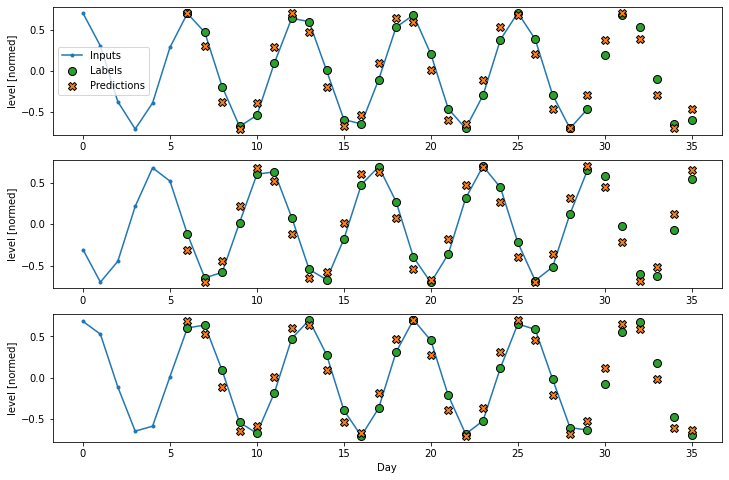

In [551]:
single_step_window.plot(baseline)


In [552]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.Huber(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

Using Huber Loss for more robustness against outliers (vs for example mean squared error)

In [553]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(8, return_sequences=True),
    tf.keras.layers.LSTM(4, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])


In [554]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', lstm_model(single_step_window.example[0]).shape)

Input shape: (32, 30, 1)
Output shape: (32, 30, 1)


In [555]:
history = compile_and_fit(lstm_model, single_step_window)
train_performance = {}
IPython.display.clear_output()
train_performance['LSTM'] = lstm_model.evaluate(single_step_window.train)
val_performance['LSTM'] = lstm_model.evaluate(single_step_window.val)
performance['LSTM'] = lstm_model.evaluate(single_step_window.test, verbose=0)



18/18 [==============================] - 0s 3ms/step - loss: 3.3354e-04 - mean_absolute_error: 0.0071


In [556]:
lstm_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 30, 8)             320       
                                                                 
 lstm_17 (LSTM)              (None, 30, 4)             208       
                                                                 
 dense_8 (Dense)             (None, 30, 1)             5         
                                                                 
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


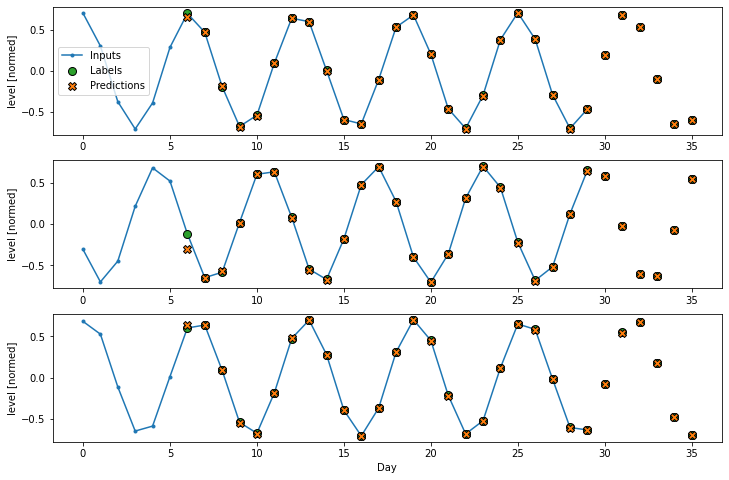

In [557]:
single_step_window.plot(lstm_model)

In [558]:
for name, value in performance.items():
    print(f'Test Mean absolute Error {name:12s}: {value[1]:0.4f}')


Test Mean absolute Error Baseline    : 0.1267
Test Mean absolute Error LSTM        : 0.0071


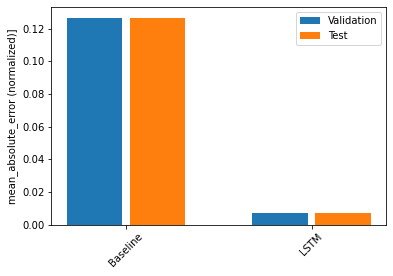

In [559]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error (normalized)]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()
plt.savefig(path + 'sine_baseline_lstm.png')

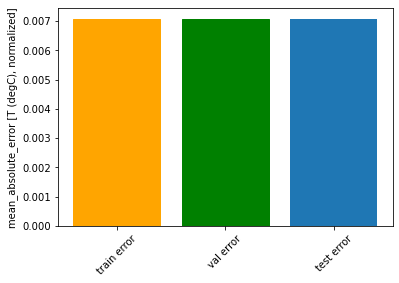

In [560]:
plt.ylabel('mean_absolute_error [T (degC), normalized]')
x = np.arange(3)
LSTM_performance = [train_performance['LSTM'][1], val_performance['LSTM'][1], performance['LSTM'][1]]
barlist = plt.bar(x, LSTM_performance)
plt.xticks(ticks=x, labels=['train error', 'val error', 'test error'],
           rotation=45)
barlist[0].set_color('orange')
barlist[1].set_color('g')
plt.savefig(path + 'sine_lstm_error.png')